# PaySim 금융 사기 탐지  

## 📓 02. 사기 거래 패턴 EDA (Fraud Patterns)

#### 사기 패턴 탐색 및 가설 수립 (The "Why")
본 노트북에서는 PaySim 데이터셋 내 사기 거래(isFraud = 1)의 **행동적·구조적 패턴을 탐색적으로 분석**한다.

핵심 질문은 다음과 같다.

- 극도로 불균형한 데이터셋에서 사기 거래의 비율은 어느 정도인가?

- 사기 거래는 어떤 거래 유형(type)에서 발생하는가?

- 의미 없는 피처(isFlaggedFraud, nameOrig 등)를 논리적으로 어떻게 소거할 것인가?

- 거래 전·후 잔액 변화(old/new balance)에 비정상적인 패턴이 존재하는가?

이를 통해 “어떤 점이 비정상 거래를 의심하게 만드는지”를 구조적으로 정리하고, 이를 통해 이후 **Feature Engineering 및 모델 설계의 결정적 근거**를 마련한다.



#### 🧩 기본 세팅 & Fraud / Non‑Fraud 분리

In [25]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
plt.style.use("seaborn-v0_8")

import warnings
warnings.filterwarnings("ignore")


pd.options.display.float_format = '{:,.0f}'.format


In [26]:
df = pd.read_csv("../data/raw/paysim.csv")

df = df.rename(columns={
    "oldbalanceOrg": "oldBalanceOrig",
    "newbalanceOrig": "newBalanceOrig",
    "oldbalanceDest": "oldBalanceDest",
    "newbalanceDest": "newBalanceDest"
})

df.head()


,step,type,amount,nameOrig,oldBalanceOrig,newBalanceOrig,nameDest,oldBalanceDest,newBalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,"9,840",C1231006815,"170,136","160,296",M1979787155,0,0,0,0
1,1,PAYMENT,"1,864",C1666544295,"21,249","19,385",M2044282225,0,0,0,0
2,1,TRANSFER,181,C1305486145,181,0,C553264065,0,0,1,0
3,1,CASH_OUT,181,C840083671,181,0,C38997010,"21,182",0,1,0
4,1,PAYMENT,"11,668",C2048537720,"41,554","29,886",M1230701703,0,0,0,0



#### 1. 타겟 분포 확인 (Class Imbalance)
먼저, 사기 거래(Fraud)와 정상 거래(Valid)의 비율을 시각화하여 데이터의 불균형 정도를 파악한다.

전체 거래 건수: 6362620
사기 거래 건수: 8213
정상 거래 건수: 6354407
사기 거래 비율: 0.129%


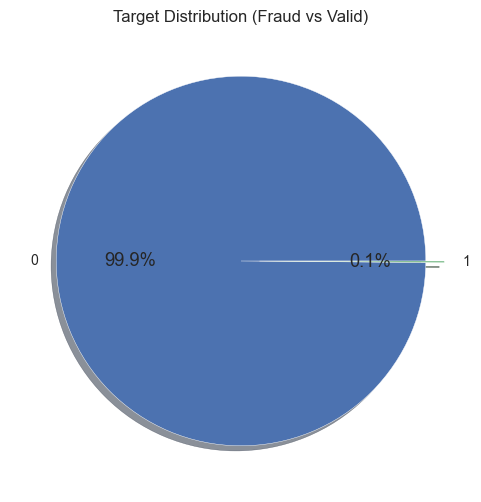

In [39]:
# 사기 거래(1)와 정상 거래(0)의 개수 확인
print('전체 거래 건수:', len(df))
print('사기 거래 건수:', len(df[df.isFraud == 1]))
print('정상 거래 건수:', len(df[df.isFraud == 0]))

fraud_ratio = len(df[df.isFraud == 1]) / len(df) * 100
print(f'사기 거래 비율: {fraud_ratio:.3f}%')

# 시각화 (Pie Chart)
f, ax = plt.subplots(1, 1, figsize=(6, 6))
df['isFraud'].value_counts().plot.pie(explode=[0, 0.1], autopct='%1.1f%%', ax=ax, shadow=True)
ax.set_title('Target Distribution (Fraud vs Valid)')
ax.set_ylabel('')
plt.show()


전체 600만 건 이상의 데이터 중 사기 거래는 단 **0.13%**에 불과한 극단적 불균형(Highly Imbalanced) 상태다.

따라서 이후 모델링 평가에서는 Accuracy(정확도)가 아닌, 소수 클래스를 잘 잡아내는지 확인하는 **AUPRC (Area Under Precision-Recall Curve)** 지표를 사용해야 한다.

#### 2. 사기가 발생하는 거래 유형 파악

모든 거래 유형에서 사기가 발생하는지, 아니면 특정 유형에 집중되어 있는지 확인하여 분석 대상을 좁힌다.

In [42]:
print('\n거래 유형별 사기 발생 건수:')
print(df.groupby('type')['isFraud'].sum())

print('\n사기 거래가 발생한 유형만 추출:')
fraud_types = list(df.loc[df.isFraud == 1].type.drop_duplicates().values)
print(fraud_types)




거래 유형별 사기 발생 건수:
type
CASH_IN        0
CASH_OUT    4116
DEBIT          0
PAYMENT        0
TRANSFER    4097
Name: isFraud, dtype: int64

사기 거래가 발생한 유형만 추출:
['TRANSFER', 'CASH_OUT']


데이터 확인 결과, 사기 거래는 오직 **TRANSFER(이체)**와 CASH_OUT(현금 인출) 두 가지 유형에서만 발생한다. 

-> 이후 분석 및 모델링에서는 데이터의 효율성을 위해 TRANSFER와 CASH_OUT 데이터만 필터링하여 사용하겠다.

#### 3. 무의미한 변수 소거 (Variable Selection)

데이터 설명서에 기재된 내용과 실제 데이터가 일치하는지 검증하고, 불필요한 변수(isFlaggedFraud, 계좌명 등)를 삭제할 근거를 찾는다.

##### 3-1. isFlaggedFraud 변수 검증
이 변수는 시스템이 사기를 의심하여 미리 플래그를 세운 것이다. 실제로 얼마나 유용한지 확인한다.

In [43]:
print('isFlaggedFraud가 1인 거래 건수:', len(df[df.isFlaggedFraud == 1]))
print('실제 사기(isFraud=1) 중 isFlaggedFraud가 1인 비율:',
      len(df[(df.isFraud == 1) & (df.isFlaggedFraud == 1)]) / len(df[df.isFraud == 1]))


isFlaggedFraud가 1인 거래 건수: 16
실제 사기(isFraud=1) 중 isFlaggedFraud가 1인 비율: 0.0019481310118105442


- isFlaggedFraud: 600만 건 중 단 16건만 플래그가 설정되어 있어, 어떤 피처와도 유의미한 상관관계가 없다.

##### 3-2. 계좌 이름(nameOrig, nameDest) 패턴 확인
사기꾼들이 특정 계좌를 반복해서 사용하는지 확인한다.

In [45]:
# 사기 계좌의 연결성 (TRANSFER 수신자가 CASH_OUT 송신자인지)
fraud_transfers = df[(df.isFraud == 1) & (df.type == 'TRANSFER')]
fraud_cashouts = df[(df.isFraud == 1) & (df.type == 'CASH_OUT')]

print('사기 TRANSFER 수신 계좌가 사기 CASH_OUT 송신 계좌와 일치하는가?',
      fraud_transfers.nameDest.isin(fraud_cashouts.nameOrig).any())


사기 TRANSFER 수신 계좌가 사기 CASH_OUT 송신 계좌와 일치하는가? False


- nameOrig, nameDest: 데이터 설명에서는 "사기 계좌로 이체 후, 그 계좌에서 인출한다"고 했으나, 
    
    실제 데이터에선 TRANSFER 수신 계좌와 CASH_OUT 송신 계좌가 일치하는 경우가 전혀 없다.
    
    → 결론: isFlaggedFraud, nameOrig, nameDest는 모델링에서 제외

#### 4. 잔액(Balance)의 모순 패턴 발견
이 섹션은 사기 탐지를 위한 가장 결정적인 단서를 찾아내는 과정이다.

정상 거래와 사기 거래의 계좌 잔액 변화 패턴을 비교한다.

##### 발견 1. 수신 계좌 잔액이 '0'으로 굳어 있는 비정상 패턴

일반적으로 돈을 받으면(TRANSFER), 수신 계좌의 잔액은 늘어나야 한다.. 하지만 사기 거래에서는 이상한 패턴이 관찰된다.

사기 거래 중 수신 잔액이 0인 비율: 49.56%
정상 거래 중 수신 잔액이 0인 비율: 0.06%


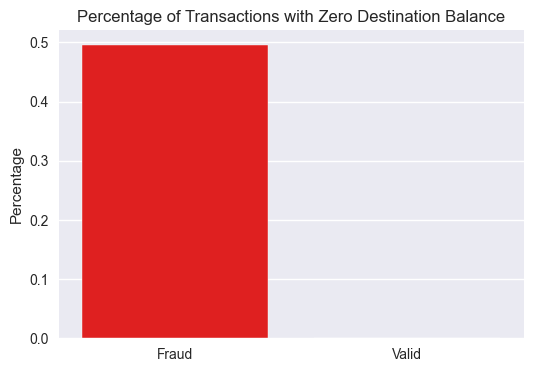

In [46]:
# TRANSFER, CASH_OUT 데이터만 분리
X = df[(df.type == 'TRANSFER') | (df.type == 'CASH_OUT')].copy()

# 거래 금액이 0이 아닌데, 수신 계좌 잔액(old/new)이 모두 0인 비율 계산
fraud_zero_dest = len(X[(X.isFraud == 1) & (X.oldBalanceDest == 0) & (X.newBalanceDest == 0) & (X.amount > 0)]) / len(X[X.isFraud == 1])
valid_zero_dest = len(X[(X.isFraud == 0) & (X.oldBalanceDest == 0) & (X.newBalanceDest == 0) & (X.amount > 0)]) / len(X[X.isFraud == 0])

print(f"사기 거래 중 수신 잔액이 0인 비율: {fraud_zero_dest * 100:.2f}%")
print(f"정상 거래 중 수신 잔액이 0인 비율: {valid_zero_dest * 100:.2f}%")

# 시각화
plt.figure(figsize=(6, 4))
sns.barplot(x=['Fraud', 'Valid'], y=[fraud_zero_dest, valid_zero_dest], palette=['red', 'green'])
plt.title('Percentage of Transactions with Zero Destination Balance')
plt.ylabel('Percentage')
plt.show()


- 거래 금액이 오갔음에도 수신 계좌의 이전/이후 잔액이 모두 0인 경우가 사기 거래에서는 무려 50%에 육박한다. 
- 반면 정상 거래에서는 0.06%에 불과하다.

->  이는 시스템이 의도적으로 0으로 표기했거나, 사기꾼이 잔액 정보를 은폐한 강력한 **사기 징후(Fraud Indicator)** 다.

##### 발견 2. 잔액 정합성(Balance Logic) 오류의 양극화 현상

정상적인 거래라면 송금 후 잔액 + 거래 금액 - 송금 전 잔액 = 0 이어야 합니다. 

이 수식을 적용해 **송신/수신 계좌의 잔액 오차(Error)** 를 계산해 비교해 봅니다.

In [ ]:
# 송신/수신 계좌의 잔액 오차 계산
X['errorBalanceOrig'] = X.newBalanceOrig + X.amount - X.oldBalanceOrig
X['errorBalanceDest'] = X.oldBalanceDest + X.amount - X.newBalanceDest
Y = X['isFraud']

# 사기 vs 정상 거래의 평균 오차 비교 
print('[송신 계좌 오차 평균]')
print('사기 거래:', X[Y == 1]['errorBalanceOrig'].mean())
print('정상 거래:', X[Y == 0]['errorBalanceOrig'].mean())

print('\n[수신 계좌 오차 평균]')
print('사기 거래:', X[Y == 1]['errorBalanceDest'].mean())
print('정상 거래:', X[Y == 0]['errorBalanceDest'].mean())


[송신 계좌 오차 평균]
사기 거래: 10692.32526482406
정상 거래: 286803.5099542466

[수신 계좌 오차 평균]
사기 거래: 732509.3010690369
정상 거래: -30910.325352107528


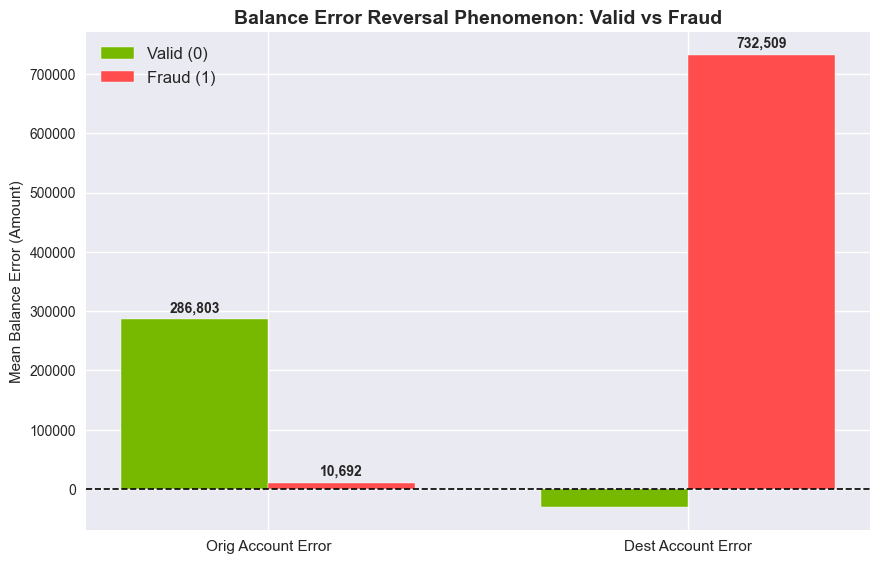

In [56]:

# 1. 평균값 데이터 준비
labels = ['Orig Account Error\n', 'Dest Account Error\n']
fraud_means = [X[Y == 1]['errorBalanceOrig'].mean(), X[Y == 1]['errorBalanceDest'].mean()]
valid_means = [X[Y == 0]['errorBalanceOrig'].mean(), X[Y == 0]['errorBalanceDest'].mean()]

x = np.arange(len(labels))  # x축 위치
width = 0.35  # 막대 두께

# 2. 그래프 그리기
fig, ax = plt.subplots(figsize=(9, 6))

# 정상 거래(초록색)와 사기 거래(빨간색) 막대 생성
rects1 = ax.bar(x - width/2, valid_means, width, label='Valid (0)', color='#76b900')
rects2 = ax.bar(x + width/2, fraud_means, width, label='Fraud (1)', color='#ff4d4d')

# 3. 그래프 꾸미기
ax.set_ylabel('Mean Balance Error (Amount)')
ax.set_title('Balance Error Reversal Phenomenon: Valid vs Fraud', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(labels, fontsize=11)
ax.legend(fontsize=12)

# y=0 기준선 추가 (수신 계좌 정상 거래가 마이너스인 것을 강조하기 위해)
ax.axhline(0, color='black', linewidth=1.2, linestyle='--')

# 막대 위에 정확한 수치 표시
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        # 음수인 경우 라벨을 막대 아래에 표시
        label_y = height if height >= 0 else height - 50000
        ax.annotate(f'{int(height):,}',
                    xy=(rect.get_x() + rect.get_width() / 2, label_y),
                    xytext=(0, 3 if height >= 0 else -15),  # 수직 오프셋
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=10, fontweight='bold')

autolabel(rects1)
autolabel(rects2)

plt.tight_layout()
plt.show()


예상치 못한, 그러나 매우 규칙적인 역전 현상이 발견됨.

- 송신 계좌(Orig): 정상 거래의 오차가 사기 거래보다 압도적으로 크다.
    - 정상 거래는 시스템 마스킹으로 인해 송신 잔액이 0으로 처리되어 발생하는 '가짜 오차'가 많은 반면, 사기 거래는 타겟 계좌의 돈을 1원 단위까지 100% 털어가기 때문에(amount == oldBalance) 수학적으로 딱 - 맞아떨어져 오차가 거의 없다.




- 수신 계좌(Dest): 반대로 수신 계좌에서는 사기와 정상 거래의 오차 방향이 완전히 반대로 갈라진다.
    - 정상 거래는 평균적으로 마이너스(-3만) 오차를 띠는데, 이는 동시다발적인 배경 입금 등으로 인해 수신 잔액이 예상보다 더 커지기 때문이다. => 값이 마이너스가 나왔다는 건, 수학적으로 newBalanceDest (송금 후 잔액)가 예상보다 더 크다는 뜻. 즉, 계좌에 내가 보낸 돈(amount)보다 돈이 더 많이 들어왔다.

    
    - 반면 사기 거래는 평균 +73만이라는 엄청난 양(+)의 오차를 가진다(잔액이 예상보다 엄청나게 빈다). 돈이 큰 액수로 입금되었음에도 수신계좌의 잔액이 0으로 은폐되는 현상이 빈번하기 때문이다.


결론적으로, 정상과 사기 데이터는 이 오차 축을 기준으로 서로 완전히 반대편(음수 vs 극단적 양수)에 위치하게 된다.

#### 5. 최종 결론 및 가설 수립 (Conclusion & Hypothesis)
EDA를 통해 단순한 '금액의 크기'가 아닌, **시스템에 데이터가 기록되는 메커니즘 자체에 내재된 사기 거래만의 고유한 지문(Fingerprint)** 을 찾아냄.

1. "사기 거래는 수학적 정합성이 깨져 있다."

- 정상 거래라면 oldBalance(송금 전 잔액) - amount(송금액) = newBalance(송금 후 잔액)이 성립해야 한다.

- 하지만 사기 거래는 이 규칙을 위반하는 경우가 많다.

2. "따라서, 잔액 오차(Balance Error)를 새로운 변수로 만들어 수치화하면  사기를 잡을 수 있다."

- 단순히 amount나 balance 값을 쓰는 것보다, errorBalance = newBalance + amount - oldBalance 라는 파생 변수를 추가하면, 모델이 이 "깨진 패턴"을 학습하여 사기를 강력하게 분류할 수 있을 것이다.





Next Step: 이 가설을 검증하기 위해 Feature Engineering 단계에서 errorBalance 변수를 실제로 생성하고, 시각화를 통해 검증


- 분석에 무의미한 isFlaggedFraud, nameOrig, nameDest 변수를 삭제한다.

- 사기가 발생하지 않는 PAYMENT, CASH_IN, DEBIT 거래를 데이터셋에서 제외한다.

- 잔액 정합성 오류를 모델이 학습할 수 있도록 errorBalanceOrig 와 errorBalanceDest 라는 새로운 파생 변수를 설계한다.


